# Outline:

* Membership Inference Attacks (MIA) on Machine Learning Models
  * Definition
  * Types of Membership Inference Attacks
  * Membership Inference Attack Methods
  * Defences Against Membership Inference Attacks

*   Membership Inference Attack in Tensorflow Privacy

*   Defending the Membership Inference Attacks Using Differential Privacy in Tensorflow Privacy

*   Defending the Membership Inference Attacks Using Sharness Aware Minimiztion scheme which has been proposed in [this](https://openreview.net/forum?id=6Tm1mposlrM) paper as a method for improving generalization. 



* References


**Note:** This notebook has been created based on the [Tensorflow Privacy Tutorials](https://github.com/tensorflow/privacy/tree/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack) from the Tensorflow Privacy package.

# Membership Inference Attacks (MIA) on Machine Learning Models 
## Definition

* MIA on machine learning models aim to identify whether a data sample
was used to train the target machine learning model or not

  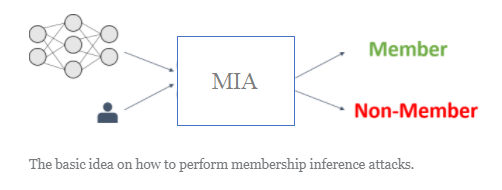



* MIA can raise severe privacy risks to
individuals. For example, identifying that a certain patient’s clinical record was used to train a model associated with a disease reveals that the patient has this disease

## Types of Membership Inference Attacks

### MIA against ML models mainly focus on deep learning models because they are more prone to suffer from overfitting issues, which can be exploited by membership inference attacks

### Based on what information is available to the adversary, i.e., adversarial knowledge, membership inference attacks can be divided as follows:


*  Black-box inference attacks
*  White-box inference attacks


### Adversarial knowledge categorization
* Data knowledge: Knowledge of the data distribution of 𝐷𝑡𝑟𝑎𝑖𝑛
* Training knowledge:  Optimization algorithm, number of training steps, settings of the optimization algorithm,
etc.
* Model knowledge:
  *  Model architecture: Type of neural network, the number of layers, the type of activation function, etc. 
  *  Model parameters
* Output knowledge:
  * Full output knowledge 
  * Partial output knowledge
  * Label-only knowledge

###Generally, the adversary is assumed to have data knowledge, training knowledge, and output knowledge of the target model. Based on whether the adversary can have access to the model knowledge of model parameters, MIA can be categorized into **black-box** and **white-box** inference attacks. In the following Table, we compare and intuitively demonstrate these two types of inferences.












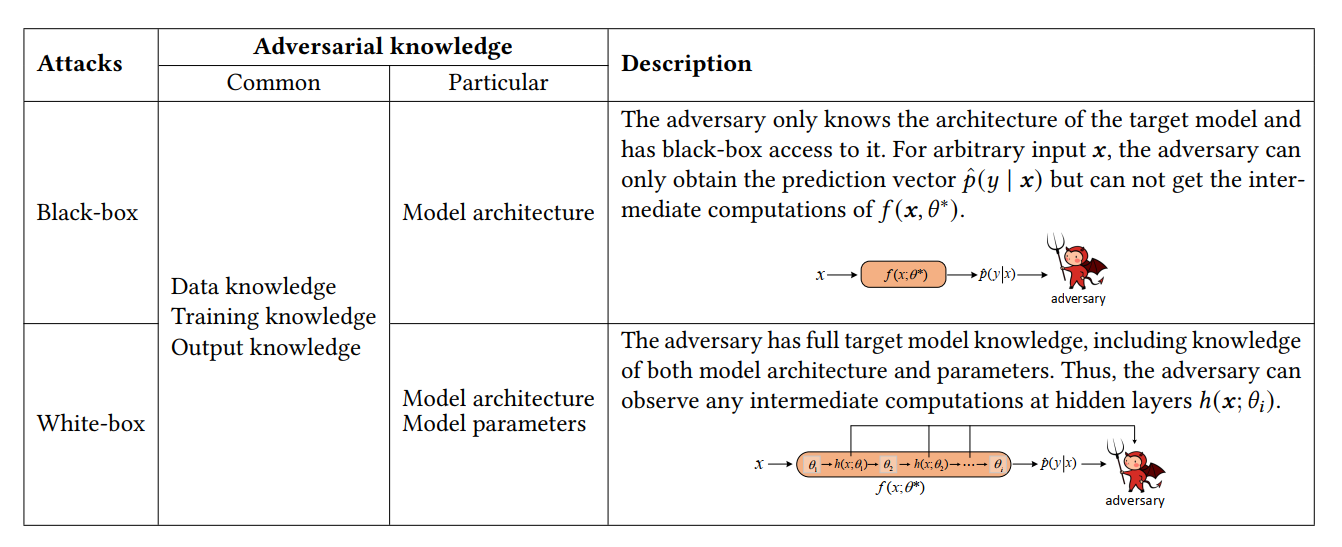


## Membership Inference Attack (MIA) Methods

### If our ML method behaves differently on test and train datasets, this model is vulnerable to MIA. This means the ML methods that overfit on the train data are more vulnerable to MIA.

### There are two types of MIA attacks:
   * Neural network based attacks
   * Metric based attacks

### Neural network based attacks

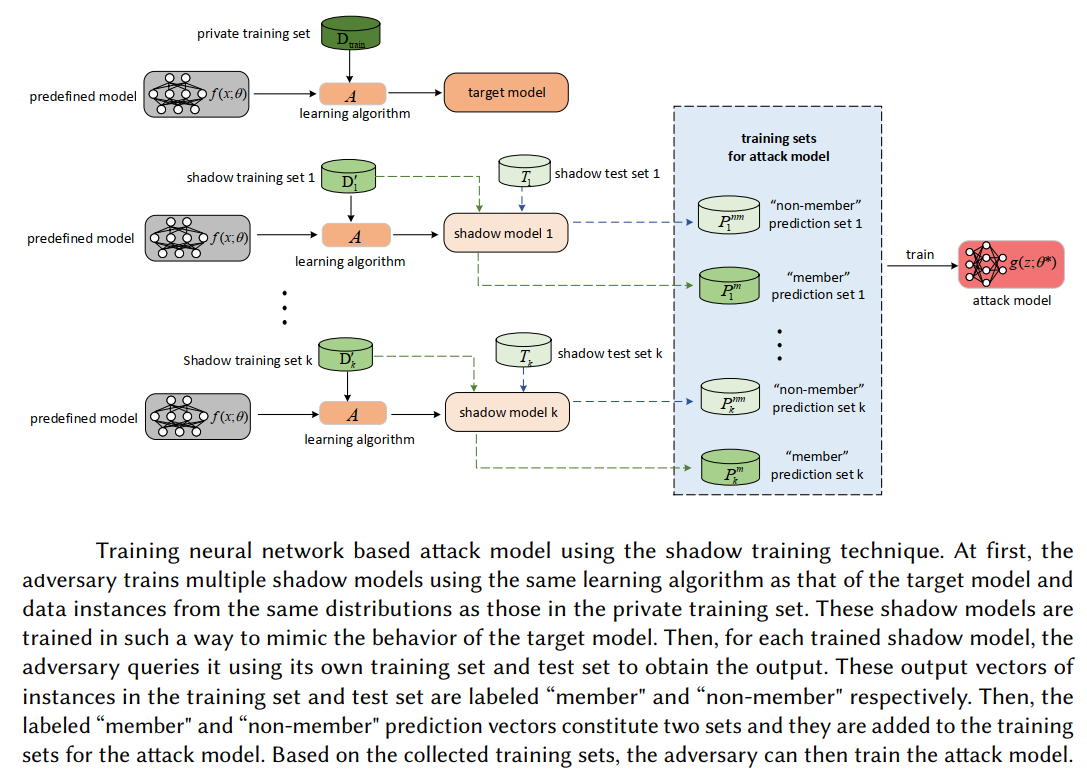

### Metric based attacks
* Prediction correctness based attack
* Prediction loss based attack
* Prediction confidence based attack
* Prediction entropy based attack

## Defences Against Membership Inference Attacks
* Confidence score masking
* Regularization
* Differential privacy
* Any approach that improves generalization of deep networks

# A simple example on doing Membership Inference Attacks with TensorFlow Privacy

### Importing Required Packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy import special
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

### Installation of packages (for running on colab)
If you use colab, uncomment and run the following cell which install the most recent verson of tensorflow-privacy.

In [ ]:
#!pip install -U git+https://github.com/tensorflow/privacy

In [3]:
# tensorflow-privacy
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
from tensorflow_privacy.privacy.membership_inference_attack import (
    membership_inference_attack as mia,
)
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import (
    AttackInputData,
    AttackType,
    SlicingSpec,
)

/usr/local/lib/python3.7/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:19: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  "\nMembership inference attack sources were moved. Please replace"


In the above cell, the first line imports the membership inference attack itself. 
The next three lines import data structures required for the attack. In the follownig, We will provide explanations on each separately.

<br>

`AttackInputData:` is used to specify what information *f*<sub>*attack*</sub>
 will receive. The *f*<sub>*attack*</sub>  is the binary classifier trained to predict, whether this data point was part of the training data or not. The input for the training the *f*<sub>*attack*</sub> are outputs (or other whitebox-like information) of a trained shadow models and the binary target is based on the dact that data has beeb used for training the associated shadow model.
 
You can specify the followings as `AttackInputData`:

* `train and test logits` or `train and test probabilities`
* `train and test loss`
* `train and test labels` (as integer arrays)

Either labels, logits, or losses should be set to be able to perform the attack. As we will see these attributes can be obtained from our trained model.


<br>

`SlicingSpec`: This one provide us with the possibility of slicing our dataset. In fact, by the help of this, we can determine the success of the membership inference attack over specific data groups or classes. According to the code you have the following options that can be set to True:

* entire_dataset: one of the slices will be the entire dataset
* by_class: one slice per class is generated
* by_percentiles: generates 10 slices for percentiles of the loss - 0-10% 10-20%, … 90-100%
* by_classification_correctness: creates one slice for correctly classified data points, and one for misclassified data points. 


<br>

`AttackType`: gives us different options on how our membership inference attack should be conducted.

* LOGISTIC_REGRESSION = ‘lr’
* MULTI_LAYERED_PERCEPTRON = ‘mlp’
* RANDOM_FOREST = ‘rf’
* K_NEAREST_NEIGHBORS = ‘knn’
* THRESHOLD_ATTACK = ‘threshold’
* THRESHOLD_ENTROPY_ATTACK = ‘threshold-entropy’

The four first options require training a shadow model, the two last options don’t.

###  Helper functions for loading cifar10 dataset and creating a simple CCN image classification mode.

In [4]:
def load_cifar10():
    """Loads MNIST-Dataset and preprocesses to combine training and test data."""

    # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
    train, test = tf.keras.datasets.cifar10.load_data()
    train_data, train_labels = train
    test_data, test_labels = test

    # scale the images from color values 0-255 to numbers from 0-1 to help the training process
    train_data = np.array(train_data, dtype=np.float32) / 255
    test_data = np.array(test_data, dtype=np.float32) / 255

    train_labels = np.array(train_labels, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)

    # cifar10 labels come one-hot encoded, there
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()

    return train_data, train_labels, test_data, test_labels


def make_CNN():
    """Define a Keras model without much of regularization
    Such a model is prone to overfitting"""
    shape = (32, 32, 3)
    input = Input(shape=shape)
    x = Conv2D(32, (3, 3), activation="relu")(input)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation="relu")(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation="relu")(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    # if we don't specify an activation for the last layer, we can have the logits
    x = Dense(10)(x)
    model = Model(input, x)
    return model

### Loading the dataset

In [5]:
train_data, train_labels, test_data, test_labels = load_cifar10()

### Visualizing some of the training images

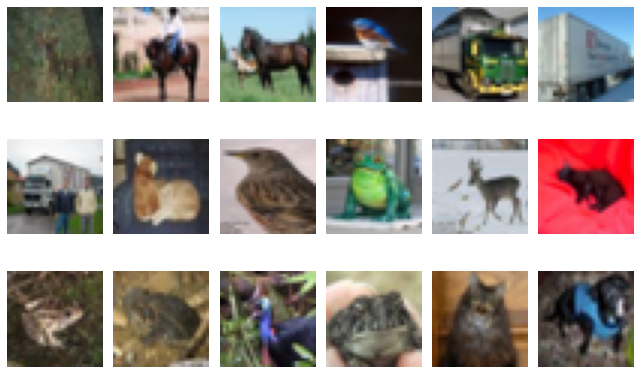

In [6]:
# show some train data
num_row = 3
num_col = 6
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(18):
    ax = axes[i // num_col, i % num_col]
    ax.set_axis_off()
    ax.imshow(train_data[i+10])

plt.tight_layout()
plt.show()

In [7]:
train_data.shape

(50000, 32, 32, 3)

### Creating the CNN model

In [8]:
# make the CNN with the "make_CNN" function created above.
model = make_CNN()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

### Specifing the parameters and compiling the model

In [9]:
# specify parameters
learning_rate=0.0005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

## Model Training
Train the model.

After trainig the model, we use the TensorFlow Privacy Library on the trained models in order to quantify the membership inference risk. 


In [10]:
# train the model
epochs = 70
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    batch_size=128,
    epochs=epochs,
)

Epoch 1/70
391/391 [==============================] - 61s 156ms/step - loss: 1.7772 - accuracy: 0.3477 - val_loss: 1.5399 - val_accuracy: 0.4393
Epoch 2/70
391/391 [==============================] - 60s 153ms/step - loss: 1.4552 - accuracy: 0.4751 - val_loss: 1.3966 - val_accuracy: 0.4966
Epoch 3/70
391/391 [==============================] - 60s 154ms/step - loss: 1.3236 - accuracy: 0.5280 - val_loss: 1.2847 - val_accuracy: 0.5456
Epoch 4/70
391/391 [==============================] - 60s 154ms/step - loss: 1.2383 - accuracy: 0.5625 - val_loss: 1.2251 - val_accuracy: 0.5711
Epoch 5/70
391/391 [==============================] - 60s 153ms/step - loss: 1.1726 - accuracy: 0.5890 - val_loss: 1.1896 - val_accuracy: 0.5838
Epoch 6/70
391/391 [==============================] - 60s 153ms/step - loss: 1.1204 - accuracy: 0.6063 - val_loss: 1.1357 - val_accuracy: 0.6007
Epoch 7/70
391/391 [==============================] - 60s 153ms/step - loss: 1.0609 - accuracy: 0.6264 - val_loss: 1.0802 - val_ac

(0.0, 1.0)

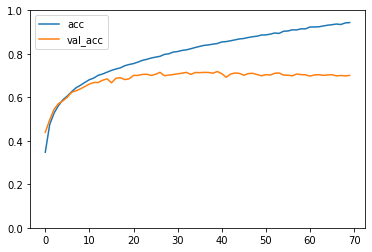

In [11]:
# plot accuracy for the first model
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.ylim(0, 1)

### Attack on the model:

Before conducting the attack, we need to calculate the inputs that attacker needs. Here we calculate the output logits, output probabilities, and losses for train and test splits.

In [12]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print("Predict on train...")
logits_train = model.predict(train_data)
print("Predict on test...")
logits_test = model.predict(test_data)

print("Apply softmax to get probabilities from logits...")
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print("Compute losses...")
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(
    constant(y_train_onehot), constant(prob_train), from_logits=False
).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


### Define what variables our attacker should have access to

After calculating the necessary input for creating our attackers, using the `AttackInputData` we define variables that our attacker have access to

In [13]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
    logits_train=logits_train,
    logits_test=logits_test,
    loss_train=loss_train,
    loss_test=loss_test,
    labels_train=train_labels.astype(np.int8),
    labels_test=test_labels.astype(np.int8),
)

### Specifying the data partitions that we would like run attacks on them.
Data partitions are defined using the `SlicingSpec`

In [14]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset=True,
    by_class=True,
    by_percentiles=False,
    by_classification_correctness=True,
)

### Defining type of attackers that we use. 

Here I am choosing the THRESHOLD_ATTACK and LOGISTIC_REGRESSION as my attack types.

In [15]:
# define the type of attacker model that we want to use
attack_types = [AttackType.THRESHOLD_ATTACK, AttackType.LOGISTIC_REGRESSION]

### Running the attack
After creating the attack_input, slicing_spec, and attack_types we can run the defined attacks as follows

In [16]:
# run the attack
attacks_result = mia.run_attacks(
    attack_input=attack_input, slicing_spec=slicing_spec, attack_types=attack_types
)

The `attack_result` object can provide us with some thorough insight into the attack. We can, for example, use the following code to see the attack results specified per-slice, as we have requested attacks by class and by model's classification correctness.

In [17]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 2132 training and 2132 test examples) achieved an AUC of 0.84 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 2132 training and 2132 test examples) achieved an advantage of 0.55 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.66
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an advantage of 0.28

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.63
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an advantage of 0.24

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.64
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 

### In addition to a written summary, you can also plot the ROC curve of the most successful attack

Figure(432x288)


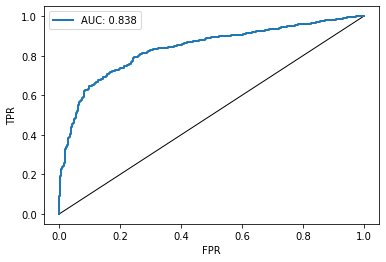

In [18]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

## Defending the Membership Inference Attacks Using Differential Privacy in Tensorflow Privacy

Here we replace the Adam optimizer with its differentially private counterpart to see how differential privacy can improve robustness against the MIA.

All the above steps will be taken again. The only change is replacing Adam with its differentially private counterpart.

In [19]:
# make the CNN with the "make_CNN" function created above.
model = make_CNN()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          3692

In [20]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

In [21]:
# specify parameters

noise_multiplier = 0.01
l2_norm_clip = 1
num_microbatches = 1
learning_rate=0.005

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate,
)

# Options for DP SGD:
# optimizer = DPKerasSGDOptimizer(
#             l2_norm_clip=l2_norm_clip,
#             noise_multiplier=noise_multiplier,
#             num_microbatches=num_microbatches,
#             learning_rate=learning_rate)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [22]:
# train the model
epochs = 70
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    batch_size=128,
    epochs=epochs,
)

Epoch 1/70
391/391 [==============================] - 62s 152ms/step - loss: 1.7981 - accuracy: 0.3337 - val_loss: 1.5366 - val_accuracy: 0.4476
Epoch 2/70
391/391 [==============================] - 60s 153ms/step - loss: 1.4734 - accuracy: 0.4666 - val_loss: 1.4982 - val_accuracy: 0.4672
Epoch 3/70
391/391 [==============================] - 60s 153ms/step - loss: 1.3966 - accuracy: 0.4955 - val_loss: 1.3887 - val_accuracy: 0.5103
Epoch 4/70
391/391 [==============================] - 60s 153ms/step - loss: 1.3548 - accuracy: 0.5129 - val_loss: 1.3915 - val_accuracy: 0.4965
Epoch 5/70
391/391 [==============================] - 59s 152ms/step - loss: 1.3464 - accuracy: 0.5176 - val_loss: 1.3618 - val_accuracy: 0.5153
Epoch 6/70
391/391 [==============================] - 60s 153ms/step - loss: 1.3441 - accuracy: 0.5207 - val_loss: 1.4104 - val_accuracy: 0.5113
Epoch 7/70
391/391 [==============================] - 60s 152ms/step - loss: 1.3340 - accuracy: 0.5259 - val_loss: 1.4194 - val_ac

(0.0, 1.0)

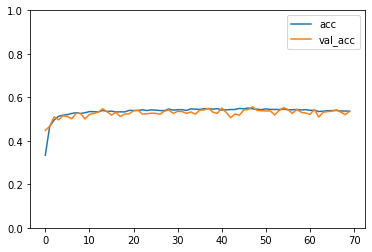

In [23]:
# plot accuracy for the first model
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.ylim(0, 1)

In [24]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print("Predict on train...")
logits_train = model.predict(train_data)
print("Predict on test...")
logits_test = model.predict(test_data)

print("Apply softmax to get probabilities from logits...")
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print("Compute losses...")
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(
    constant(y_train_onehot), constant(prob_train), from_logits=False
).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


In [25]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
    logits_train=logits_train,
    logits_test=logits_test,
    loss_train=loss_train,
    loss_test=loss_test,
    labels_train=train_labels.astype(np.int8),
    labels_test=test_labels.astype(np.int8),
)

In [26]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset=True,
    by_class=True,
    by_percentiles=False,
    by_classification_correctness=True,
)

In [27]:
# define the type of attacker model that we want to use
attack_types = [AttackType.THRESHOLD_ATTACK, AttackType.LOGISTIC_REGRESSION]

In [28]:
# run the attack
attacks_result = mia.run_attacks(
    attack_input=attack_input, slicing_spec=slicing_spec, attack_types=attack_types
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [29]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an AUC of 0.52 on slice CLASS=3
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.08 on slice CLASS=6

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.04

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.05

Best-performing attacks over slice: "CLAS

Figure(432x288)


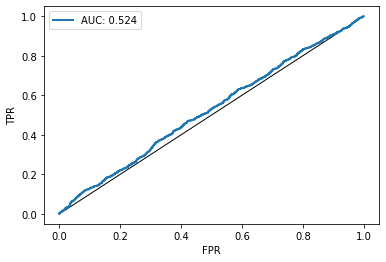

In [30]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting

print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

## Defending the Membership Inference Attacks Using Sharness Aware Minimiztion scheme

Here we replace the Adam optimizer with Sharpness Aware Minimiztion (SAM) scheme to see how SAM optimizer improve robustness against the MIA.

Here we implement the SAM shceme which developed by authors in the paper [Sharpness-aware Minimization for Efficiently Improving Generalization](https://openreview.net/forum?id=6Tm1mposlrM) and train our CNN using this optimizer. Then, we use MIA and test robustness of the model trained using SAM scheme.

### Implementation of  Sharpness-aware Minimization for Efficiently Improving Generalization [this](https://openreview.net/forum?id=6Tm1mposlrM) paper. 

This implementation is inspired by the implementations in [this](https://github.com/google-research/sam) and [this](https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow) and repositories.

In [31]:
# make the CNN with the "make_CNN" function created above.
model = make_CNN()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          3692

In [32]:
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

class SAM(tf.keras.Model):
    def __init__(self, model,rho=.5, **kwargs):
        super(SAM, self).__init__(**kwargs)
        self.model = model
        self.rho = rho
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.pd_classification_loss_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="SparseCategoricalAccuracy")
        self.epoch_accuracy_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="classification_accuracy")

    def call(self,x):
        return  self.model(x)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.pd_classification_loss_tracker,
            self.epoch_accuracy_tracker
        ]

    def train_step(self, data):
        x,y= data
        e_ws = []
                
        with tf.GradientTape() as tape:
            prediction = self.model(x)
            classification_loss = tf.reduce_mean(cce(y,prediction))
        
        trainable_params = self.model.trainable_variables
        gradients = tape.gradient(classification_loss, self.trainable_weights)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.model(x)
            loss = tf.reduce_mean(cce(y, predictions))    
        
        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)

        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))

        self.total_loss_tracker.update_state(loss)
        self.pd_classification_loss_tracker.update_state(y,predictions)
        self.epoch_accuracy_tracker.update_state(y,predictions)
        return {
            "loss": self.total_loss_tracker.result(),
            "classification_accuracy":self.pd_classification_loss_tracker.result(),
            "classification_accuracy":self.epoch_accuracy_tracker.result(),
           
        }

    def test_step(self, data):
        val_x, val_y = data
        total_grad=[]        
        val_prediction = self.model(val_x)
        val_classification_loss = tf.reduce_mean(cce(val_y,val_prediction))

        self.total_loss_tracker.update_state(val_classification_loss)    
        self.pd_classification_loss_tracker.update_state(val_y,val_prediction)
        self.epoch_accuracy_tracker.update_state(val_y,val_prediction)
        return {
            "loss": self.total_loss_tracker.result(),
            "classification_accuracy":self.pd_classification_loss_tracker.result(),
            "classification_accuracy":self.epoch_accuracy_tracker.result(), 
        }


    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm    


In [33]:
learning_rate=.0005
epochs=70
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
SAM_model = SAM(model = model)
SAM_model.compile(optimizer=optimizer)




In [34]:
# Test if the model has been compiled correctly
SAM_model(train_data[0:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.0231301 ,  0.01666044, -0.02455717,  0.06288033, -0.04653388,
        -0.10735635, -0.00856967,  0.02972627, -0.06631181,  0.02881845]],
      dtype=float32)>

In [35]:
history=SAM_model.fit(train_data,train_labels,  epochs=epochs,batch_size=128,validation_data=(test_data, test_labels))

Epoch 1/70
391/391 [==============================] - 111s 282ms/step - loss: 2.3514 - classification_accuracy: 0.0624 - val_loss: 2.2740 - val_classification_accuracy: 0.2356
Epoch 2/70
391/391 [==============================] - 111s 283ms/step - loss: 2.2521 - classification_accuracy: 0.1845 - val_loss: 1.9791 - val_classification_accuracy: 0.3098
Epoch 3/70
391/391 [==============================] - 111s 285ms/step - loss: 2.0416 - classification_accuracy: 0.2593 - val_loss: 1.7583 - val_classification_accuracy: 0.3865
Epoch 4/70
391/391 [==============================] - 111s 285ms/step - loss: 2.0416 - classification_accuracy: 0.2563 - val_loss: 1.6663 - val_classification_accuracy: 0.4102
Epoch 5/70
391/391 [==============================] - 112s 285ms/step - loss: 1.9684 - classification_accuracy: 0.2977 - val_loss: 1.5687 - val_classification_accuracy: 0.4427
Epoch 6/70
391/391 [==============================] - 111s 285ms/step - loss: 1.8245 - classification_accuracy: 0.3547 -

In [36]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = SAM_model.predict(train_data)
print('Predict on test...')
logits_test = SAM_model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


In [37]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels.astype(np.int8),
  labels_test = test_labels.astype(np.int8)
)

In [38]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [39]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [40]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [41]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.73 on slice CLASS=2
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.36 on slice CLASS=2

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.62
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an advantage of 0.19

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.66
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.29

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.63
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an advantage of 0.20

Best-performing attacks over slice:

Figure(432x288)


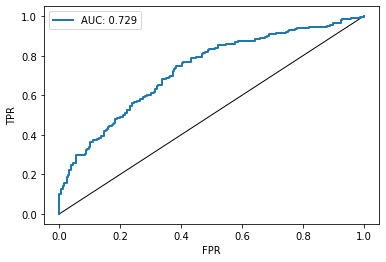

In [42]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

(0.0, 1.0)

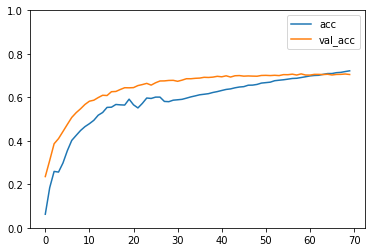

In [43]:
# plot accuracy for the first model
plt.plot(history.history['classification_accuracy'], label='acc')
plt.plot(history.history['val_classification_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

As you can see, in this experiment, SAM improves the privacy compared with the baseline model without degrading the performance. On the other hand, Although DP-SGD achieves better robusness against MIA compared with SAM and baseline methods, it significantly degraded the performance.

# References

* A survey on MIA for machine lerarning algorithms in [this](https://arxiv.org/abs/2103.07853) paper.
* Sharpness-aware Minimization for Efficiently Improving Generalization in [this](https://openreview.net/forum?id=6Tm1mposlrM) paper. 
* Tensorflow privacy [Github page](https://github.com/tensorflow/privacy/tree/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack).

* Blog posts from Franziska Boenisch on Attacks against Machine Learning Privacy [part 1](https://franziska-boenisch.de/posts/2020/12/model-inversion/) and [part 2](https://franziska-boenisch.de/posts/2021/01/membership-inference/).